# Brain stroke detection from CT scans via 3D Convolutional Neural Network

**Author**: [Giovanni Pecoraro](https://www.peco602.com)

**Created**: 2023/04/21

**Updated**: 2023/04/21

**Description**: Train a 3D Convolutional Neural Network to detect presence of brain stroke from CT scans.

## Introduction

The [Brain Stroke CT Image Dataset](https://www.kaggle.com/datasets/afridirahman/brain-stroke-ct-image-dataset) from Kaggle provides normal and stroke brain Computer Tomography (CT) scans. The dataset presents very low activity even though it has been uploaded more than 2 years ago. It may be probably due to its quite low usability (3.13). The challenge is to get some interesting result, i.e., to try to perform brain stroke detection, even from this low-quality CT scans dataset. The followed approach is based on the usage of a 3D Convolutional Neural Network (CNN) in place of a standard 2D one. 2D CNNs are commonly used to process both grayscale (1 channel) and RGB images (3 channels), while a 3D CNN represents the 3D equivalent since it takes as input a 3D volume or a sequence of 2D frames, e.g. slices in a CT scan. 
The provided example takes inspiration from the great work [3D image classification from CT scans](https://keras.io/examples/vision/3D_image_classification/) done by [Hasib Zunair](https://twitter.com/hasibzunair) who clearly demonstrated how to use a 3D CNN to predict the presence of viral pneumonia from CT scans.

## Dataset exploration

The CT scans dataset is public available on Kaggle, but for the sake of simplicy it has been made available also on my Github profile so it can be easily downloaded without the need of an API key and additional Python packages.

In [1]:
import os
import zipfile
import tensorflow as tf

# Download dataset from Github
url = "https://github.com/Peco602/brain-stroke-detection-3d-cnn/releases/download/v0.0.1/brain_ct_data.zip"
filename = os.path.join(os.getcwd(), "brain_ct_data.zip")
tf.keras.utils.get_file(filename, url)

# Unzip dataset
with zipfile.ZipFile("brain_ct_data.zip", "r") as z_fp:
    z_fp.extractall(".")

63160014/63160014 [==============================] - 1s 0us/step


In [2]:
!ls -al brain_ct_data

total 92
drwxr-xr-x 4 root root  4096 Apr 21 07:03 .
drwxr-xr-x 1 root root  4096 Apr 21 07:03 ..
drwxr-xr-x 2 root root 49152 Apr 21 07:03 Normal
drwxr-xr-x 2 root root 32768 Apr 21 07:03 Stroke


The dataset contains both normal and stroke images respectively in the `Normal` and `Stroke` folders.

In [3]:
!ls brain_ct_data/Normal | head

100 (10).jpg
100 (11).jpg
100 (12).jpg
100 (13).jpg
100 (14).jpg
100 (15).jpg
100 (16).jpg
100 (17).jpg
100 (18).jpg
100 (19).jpg


In [4]:
!ls brain_ct_data/Stroke | head

58 (10).jpg
58 (11).jpg
58 (12).jpg
58 (13).jpg
58 (15).jpg
58 (17).jpg
58 (18).jpg
58 (19).jpg
58 (1).jpg
58 (20).jpg


It is important to clarify the dataset does not contain CT scans, which are usually provided as DICOM or NIfTI files, but the CT scan slices in JPEG format (most probably extracted from DICOM or NIfTI files). A previous [post](https://www.peco602.com/post/0090-python-dicom/) clearly explains how to extract slice images from a DICOM file. Giving a further look to the slice images it is easy to understand the naming convention `PATIENT_ID (SLICE_ID).jpg`, e.g. `49 (1).jpg`, `49 (2).jpg` and for each patient ID several slices are available. The following function is able to plot up to 40 slices (if available) for a specific patient ID.


In [5]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np

def plot_scan_from_path(slices_path, patient_id):
    """Plot 40 slices for a patient ID"""
    num_rows = 4
    num_columns = 10
    factor = 1.2
    f, axarr = plt.subplots(
        num_rows,
        num_columns,
        figsize=(num_columns*factor, num_rows*factor),
    )
    f.suptitle(f"Patient {patient_id}", y=1.1)
    image_id = 1
    for i in range(num_rows):
        for j in range(num_columns):
          try:
            img = imageio.imread(f'{slices_path}/{patient_id} ({image_id}).jpg')
          except Exception as e:
            print(e)
            img = np.zeros((2,2))
          finally:
            axarr[i, j].imshow(img, cmap='gray')
            axarr[i, j].axis('off')
            image_id += 1
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

Let's start with patient 49:

No such file: '/content/brain_ct_data/Normal/49 (34).jpg'
No such file: '/content/brain_ct_data/Normal/49 (35).jpg'
No such file: '/content/brain_ct_data/Normal/49 (36).jpg'
No such file: '/content/brain_ct_data/Normal/49 (37).jpg'
No such file: '/content/brain_ct_data/Normal/49 (38).jpg'
No such file: '/content/brain_ct_data/Normal/49 (39).jpg'
No such file: '/content/brain_ct_data/Normal/49 (40).jpg'


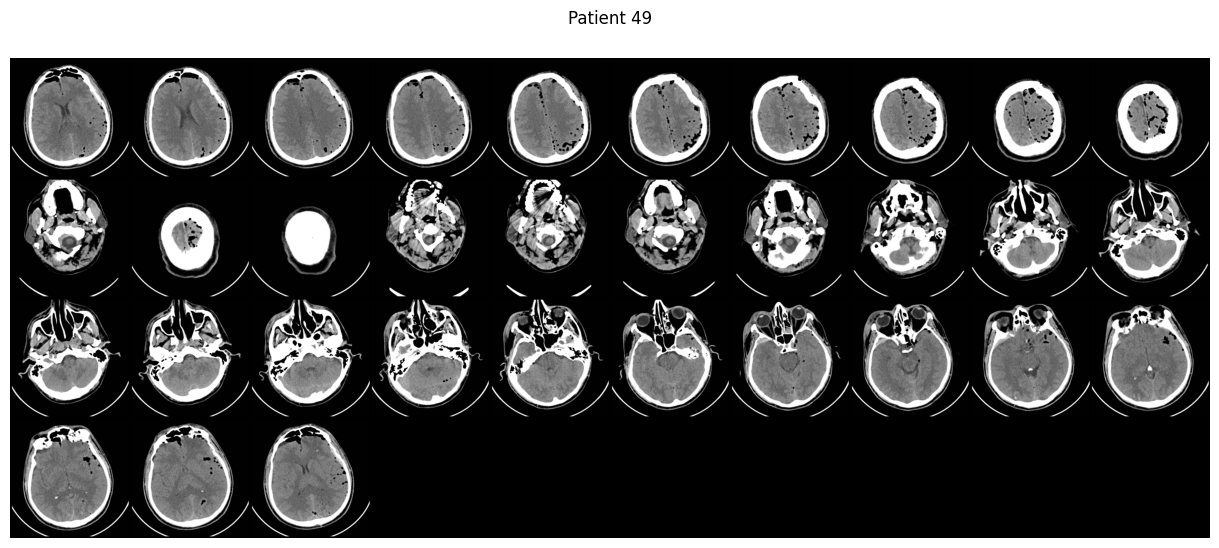

In [6]:
plot_scan_from_path(slices_path='brain_ct_data/Normal', patient_id=49)

Patient 49 has 33 slices, but it is fundamental to underline the slices are not correctly sorted. It seems the slices go from the middle of the head to the top, but then they suddenly start back from the bottom. This may be among the reasons the dataset usability is low. This may not be an issue for a 2D CNN since it takes single images as input, but is a big obstacle for a 3D CNN where the volumetric representation of the brain is needed.

No such file: '/content/brain_ct_data/Normal/50 (13).jpg'
No such file: '/content/brain_ct_data/Normal/50 (15).jpg'
No such file: '/content/brain_ct_data/Normal/50 (17).jpg'
No such file: '/content/brain_ct_data/Normal/50 (19).jpg'
No such file: '/content/brain_ct_data/Normal/50 (21).jpg'
No such file: '/content/brain_ct_data/Normal/50 (23).jpg'
No such file: '/content/brain_ct_data/Normal/50 (25).jpg'
No such file: '/content/brain_ct_data/Normal/50 (27).jpg'
No such file: '/content/brain_ct_data/Normal/50 (29).jpg'
No such file: '/content/brain_ct_data/Normal/50 (31).jpg'
No such file: '/content/brain_ct_data/Normal/50 (33).jpg'
No such file: '/content/brain_ct_data/Normal/50 (35).jpg'
No such file: '/content/brain_ct_data/Normal/50 (39).jpg'
No such file: '/content/brain_ct_data/Normal/50 (40).jpg'


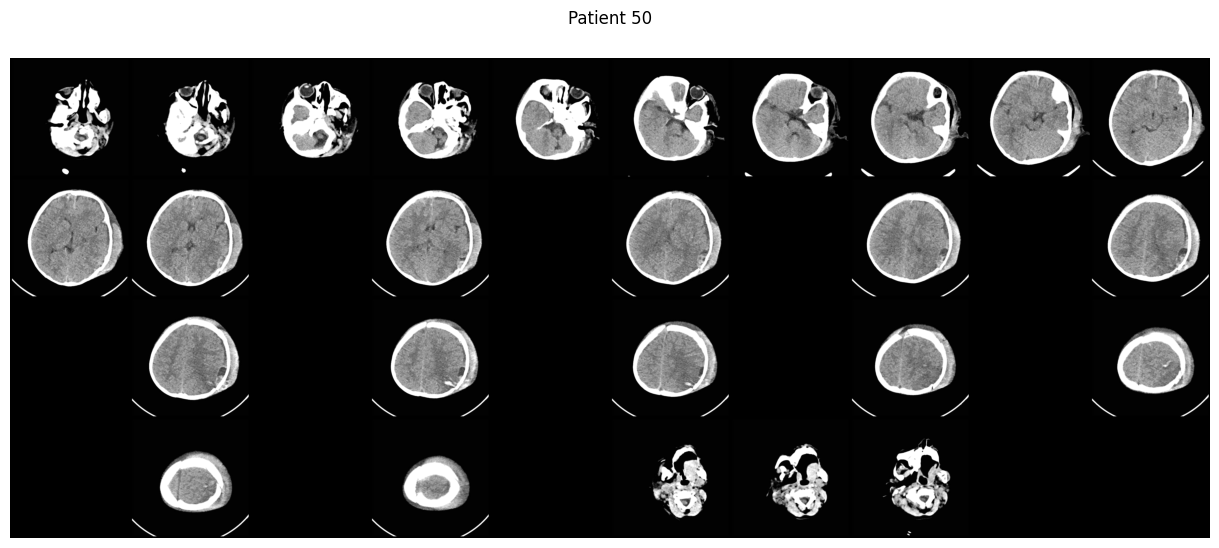

In [7]:
plot_scan_from_path(slices_path='brain_ct_data/Normal', patient_id=50)

For patient 50 the situation is even worse: there are holes in slice sequence, which makes dataset importing even more difficult.

## Dataset fixing

Before going deeper into modeling it is necessary to try to fix the dataset otherwise it is quite difficult to expect good results. If you are not interested in this section you can skip it and directly jump to the next one since the fixed dataset is also already available on my Github profile.

The fixing consists of correctly sorting the slices and removing the existing holes. The idea is to create a dictionary where each key represents a patient ID, while the value is the list of correctly sorted images. The creation of such a dictionary was quite demanding since it required to visually analyze the entire dataset to try to determine the correct sequence for each patient.

In [8]:
INPUT_PATH='brain_ct_data'
OUTPUT_PATH='brain_ct_data_fixed'
NORMAL_INPUT_PATH=f'{INPUT_PATH}/Normal'
NORMAL_OUTPUT_PATH=f'{OUTPUT_PATH}/Normal'
STROKE_INPUT_PATH=f'{INPUT_PATH}/Stroke'
STROKE_OUTPUT_PATH=f'{OUTPUT_PATH}/Stroke'

NORMAL_SORTING_CONFIG = {
    49:  [14, 15, 16, 11, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13],
    50:  [36, 37, 38, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34],
    51:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50],
    52:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    53:  [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 28, 29, 31, 33, 35, 37, 39, 41, 43, 1, 2, 3, 4],
    54:  [20, 21, 22, 23, 24, 25, 26, 27, 28, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    55:  [30, 31, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    56:  [33, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    57:  [32, 33, 34, 35, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    59:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
    60:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    61:  [25, 26, 27, 28, 29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    62:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
    63:  [33, 34, 35, 36, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    64:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    65:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    95:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    96:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
    98:  [29, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    99:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    100: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    101: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    102: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    103: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
    104: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    105: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    106: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    107: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    108: [25, 26, 27, 28, 29, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    109: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    110: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    111: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
    112: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    113: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    114: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    115: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    116: [31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    117: [29, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    118: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    119: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    120: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    121: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    122: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    123: [39, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
    124: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    125: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    126: [30, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    127: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    128: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    129: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    130: [26, 27, 28, 29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
}

STROKE_SORTING_CONFIG = {
    58: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    66: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 38, 39, 40, 41],
    67: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23, 25, 27, 28, 29, 30, 31, 32, 33],
    68: [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    69: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    70: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48],
    71: [48, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46],
    72: [31, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    73: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 32, 34, 36, 38, 39],
    74: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46],
    75: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49],
    76: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40, 41, 42, 43],
    77: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
    78: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21, 23, 25, 26, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42],
    79: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
    80: [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    81: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 44],
    82: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    83: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 29, 31, 33, 35, 36, 37, 38, 1, 2, 3, 4],
    84: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    85: [21, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20],
    86: [31, 32, 33, 34, 35, 36, 1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    87: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40, 41, 42, 43, 44],
    88: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 28, 30, 32, 34, 35, 36, 37],
    89: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23, 25, 27, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
    90: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    91: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    92: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 23, 25, 27, 29, 31, 32, 33, 34, 36, 38, 40, 42],
    93: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    94: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 44, 45, 46],
    97: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40],
}

Given both the `NORMAL_SORTING_CONFIG` and `STROKE_SORTING_CONFIG` it is just a matter of copying all the slices in the correct order to a different path, i.e., `brain_ct_data_fixed`.

In [9]:
import os
import shutil

def sort_slices(input_path, output_path, patient_id, order):
  """Copy the slices in the correct order"""
  # Create output folder for sorted images (if it does not exist)
  if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)

  # Move the image to the output path with a name based on the correct sorting order
  for new_id in range(1, len(order)+1):
    old_id = order[new_id-1]
    shutil.copyfile(f'{input_path}{os.sep}{patient_id} ({old_id}).jpg', f'{output_path}{os.sep}{patient_id} ({new_id}).jpg')


# Normal slices sorting
for patient_id, order in NORMAL_SORTING_CONFIG.items():
    sort_slices(
      input_path=NORMAL_INPUT_PATH,
      output_path=NORMAL_OUTPUT_PATH,
      patient_id=patient_id,
      order=order)

# Stroke slices sorting
for patient_id, order in STROKE_SORTING_CONFIG.items():
    sort_slices(
      input_path=STROKE_INPUT_PATH,
      output_path=STROKE_OUTPUT_PATH,
      patient_id=patient_id,
      order=order)

Let's try to plot again CT slices for both patients 49 and 50:

No such file: '/content/brain_ct_data_fixed/Normal/49 (34).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (35).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (36).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (37).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (38).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (39).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (40).jpg'


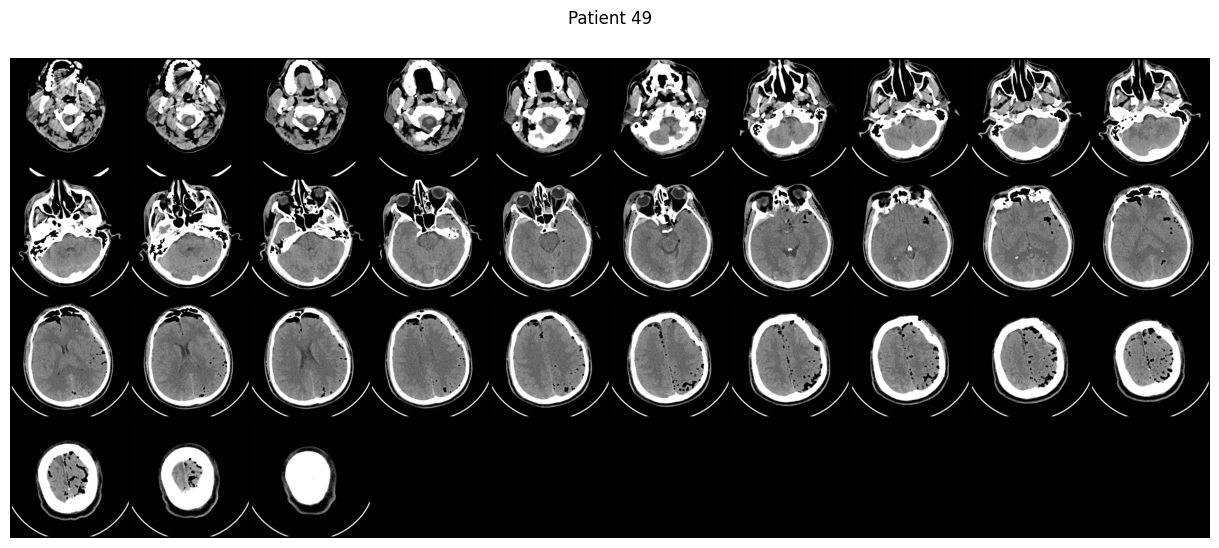

In [10]:
plot_scan_from_path(slices_path=NORMAL_OUTPUT_PATH, patient_id=49)

No such file: '/content/brain_ct_data_fixed/Normal/50 (27).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (28).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (29).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (30).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (31).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (32).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (33).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (34).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (35).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (36).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (37).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (38).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (39).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (40).jpg'


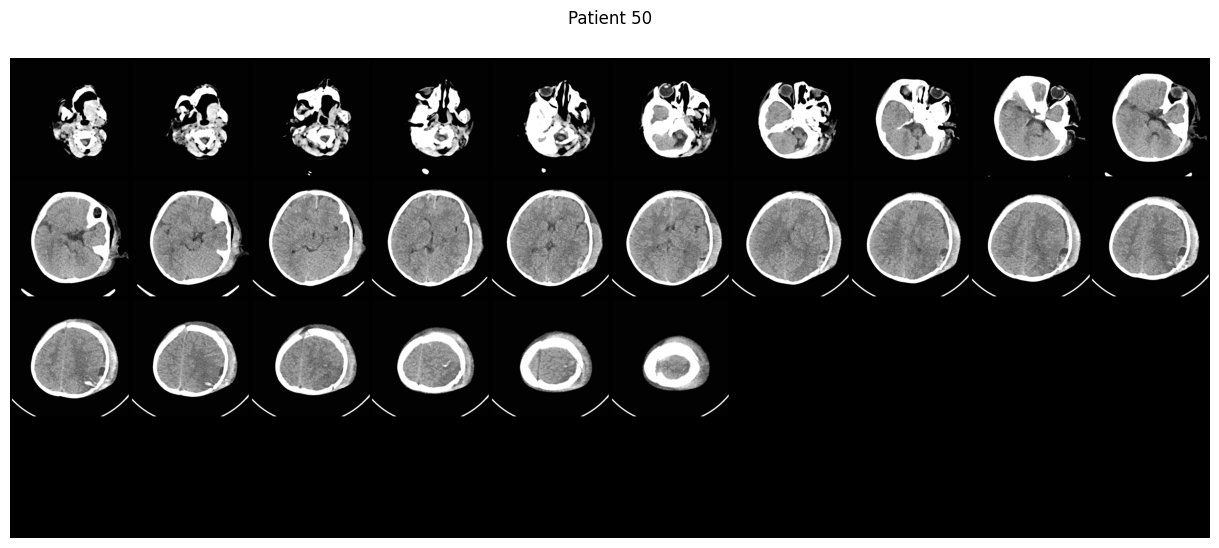

In [11]:
plot_scan_from_path(slices_path=NORMAL_OUTPUT_PATH, patient_id=50)

Hopefully, the dataset should be fixed now.

In [12]:
!zip -r brain_ct_data_fixed.zip brain_ct_data_fixed

  adding: brain_ct_data_fixed/ (stored 0%)
  adding: brain_ct_data_fixed/Normal/ (stored 0%)
  adding: brain_ct_data_fixed/Normal/113 (23).jpg (deflated 11%)
  adding: brain_ct_data_fixed/Normal/65 (26).jpg (deflated 13%)
  adding: brain_ct_data_fixed/Normal/121 (12).jpg (deflated 7%)
  adding: brain_ct_data_fixed/Normal/105 (12).jpg (deflated 10%)
  adding: brain_ct_data_fixed/Normal/64 (16).jpg (deflated 8%)
  adding: brain_ct_data_fixed/Normal/109 (11).jpg (deflated 7%)
  adding: brain_ct_data_fixed/Normal/64 (1).jpg (deflated 9%)
  adding: brain_ct_data_fixed/Normal/100 (14).jpg (deflated 7%)
  adding: brain_ct_data_fixed/Normal/53 (14).jpg (deflated 5%)
  adding: brain_ct_data_fixed/Normal/112 (22).jpg (deflated 19%)
  adding: brain_ct_data_fixed/Normal/61 (2).jpg (deflated 8%)
  adding: brain_ct_data_fixed/Normal/117 (10).jpg (deflated 8%)
  adding: brain_ct_data_fixed/Normal/110 (9).jpg (deflated 7%)
  adding: brain_ct_data_fixed/Normal/127 (6).jpg (deflated 13%)
  adding: brain

The fixed dataset is publicly available [here](https://github.com/Peco602/brain-stroke-detection-3d-cnn/releases/download/v0.0.1/brain_ct_data_fixed.zip).

## Dataset loading and preprocessing


In case the previous section has been skipped, it is possible to directly download the fixed dataset:

In [13]:
import os
import zipfile
import tensorflow as tf

# Download dataset from Github
url = "https://github.com/Peco602/brain-stroke-detection-3d-cnn/releases/download/v0.0.1/brain_ct_data_fixed.zip"
filename = os.path.join(os.getcwd(), "brain_ct_data_fixed.zip")
tf.keras.utils.get_file(filename, url)

# Unzip dataset
with zipfile.ZipFile("brain_ct_data_fixed.zip", "r") as z_fp:
    z_fp.extractall(".")

In [14]:
NORMAL_PATH = '/content/brain_ct_data_fixed/Normal'
STROKE_PATH = '/content/brain_ct_data_fixed/Stroke'

Before going deeper into data loading it can be interesting to give a look to a single CT slice.



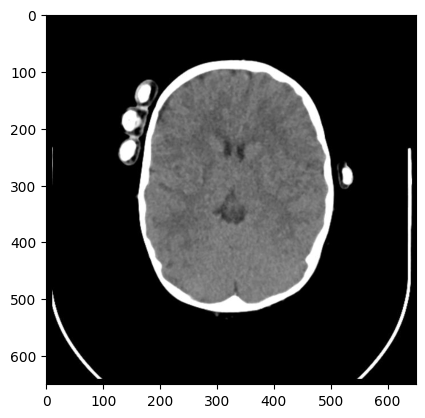

In [15]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt

image = imageio.imread(f'{STROKE_PATH}/67 (15).jpg')
plt.imshow(image, cmap="gray")

As it is possible to see, the image presents some artifacts that may hinder the CNN training process. [Vicente Rodríguez](https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography) provided a nice example of CT image denoising that lead to the creation of the following `remove_noise` function:

In [16]:
from scipy import ndimage
from skimage import morphology
import numpy as np

def remove_noise(image, display=False):
  """Remove slice noise"""
  # morphology.dilation creates a segmentation of the image
  # If one pixel is between the origin and the edge of a square of size
  # 3x3, the pixel belongs to the same class
  segmentation = morphology.dilation(image, np.ones((3, 3)))
  segmentation[segmentation < 25] = 0
  segmentation[segmentation > 25] = 1
  labels, label_nb = ndimage.label(segmentation)
  label_count = np.bincount(labels.ravel().astype(int))

  # The size of label_count is the number of classes/segmentations found.
  # The first class is not used since it's the background.
  label_count[0] = 0

  # A mask with the class with more pixels is created
  # since it should represent the brain
  mask = labels == label_count.argmax()

  # Improve the brain mask
  mask = morphology.dilation(mask, np.ones((5, 5)))
  mask = ndimage.binary_fill_holes(mask)
  mask = morphology.dilation(mask, np.ones((3, 3)))

  # Since the pixels in the mask are zeros and ones,
  # it is possible to multiple the original image to only keep the brain region
  masked_image = mask * image

  if display:
    plt.figure(figsize=(10, 2.5))
    plt.subplot(141)
    plt.imshow(image, cmap=plt.cm.bone)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(mask, cmap=plt.cm.bone)
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(masked_image, cmap=plt.cm.bone)
    plt.title('Clean Image')
    plt.axis('off')

  return masked_image

So, let's try to remove the background artifacts from the image:

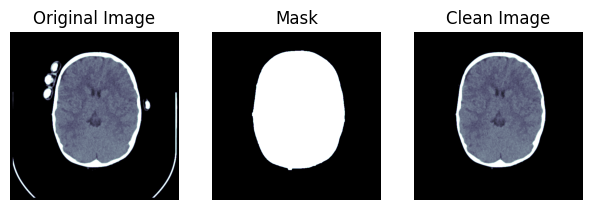

In [17]:
denoised_image = remove_noise(image, display=True)

As expected, the CT artifacts are not present anymore.

It is worth noting despite the CT slices have been correctly sorted and there are no holes in slice sequences anymore, the dataset is still not so straightforward to import since the number of slices per patient is not 
always the same. The `load_dataset` function appears quite complex because it has to execute in sequence multiple steps to load and pre-process the entire image dataset:

1. `count_slices`: counts the number of slices per patient
2. `merge_slices`: denoises (optionally) and merges all patient slices into a single scan
3. `normalize_scan`: normalizes the scan values to the interval `[0, 1]`
4. `resize_scan`: resizes the scan across x, y and z axis to uniform the scan sizes to fixed values 

Finally, the returned dataset is a 4D array, i.e., an array of scans (3D images).

In [18]:
import numpy as np
from tqdm import tqdm


def resize_scan(scan):
  """Resize the CT scan to a desired uniform size across all axis"""
  # Set the desired depth
  desired_depth = 64
  desired_width = 128
  desired_height = 128
  # Get current depth
  current_depth = scan.shape[-1]
  current_width = scan.shape[0]
  current_height = scan.shape[1]
  # Compute depth factor
  depth = current_depth / desired_depth
  width = current_width / desired_width
  height = current_height / desired_height
  depth_factor = 1 / depth
  width_factor = 1 / width
  height_factor = 1 / height
  # Rotate
  scan = ndimage.rotate(scan, 90, reshape=False)
  # Resize across z-axis
  scan = ndimage.zoom(scan, (width_factor, height_factor, depth_factor), order=1)
  return scan


def normalize_scan(scan):
  """Normalize the scan to the interval [0, 1]"""
  min = 0
  max = 255
  scan[scan < min] = min
  scan[scan > max] = max
  scan = (scan - min) / (max - min)
  scan = scan.astype("float32")
  return scan


def merge_slices(path, patient_id, slice_count, denoise=False):
  """Merge all the slices for a patient into a scan"""
  if denoise:
    scan = tuple(remove_noise(imageio.imread(f'{path}/{patient_id} ({slice_id}).jpg')) for slice_id in range(1, slice_count+1))
  else:
    scan = tuple(imageio.imread(f'{path}/{patient_id} ({slice_id}).jpg') for slice_id in range(1, slice_count+1))

  return np.dstack(scan)


def count_slices(path):
  """Analyze the slices path and returns a dictionary with the slices count associated to each patient"""
  slice_dict = {}
  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
        patient_id = int(filename.split()[0])
        if patient_id not in slice_dict:
          slice_dict[patient_id] = 1
        else:
          slice_dict[patient_id] = slice_dict[patient_id] + 1

  return slice_dict


def collect_scan(path, patient_id, slice_count):
  """Collect a scan for a patient id"""
  # Get a single CT scan by merging all the slices from a single patient
  # Before getting merged the slices are also denoised
  scan = merge_slices(path, patient_id, slice_count, denoise=True)

  # Normalize the CT scan to the interval [0, 1]
  scan = normalize_scan(scan)

  # Resize the CT scan to uniform the size
  scan = resize_scan(scan)

  return scan


def load_dataset(path):
  """Return the scans dataset as a 4D array""" 
  # Get a dictionary with patient IDs and slice count per patient
  slices_dict = count_slices(path)

  # Collect scans for each patient id
  dataset = np.array([collect_scan(path, patient_id, slice_count) for patient_id, slice_count in tqdm(slices_dict.items())])

  return dataset

Both the normal and stroke datasets are imported from the respective paths. Since the process can take some minutes the `tqdm` library can help to check the progress in realtime.

In [19]:
normal_dataset = load_dataset(path=NORMAL_PATH)
stroke_dataset = load_dataset(path=STROKE_PATH)

100%|██████████| 31/31 [01:41<00:00,  3.27s/it]


In [20]:
normal_dataset.shape, stroke_dataset.shape

((51, 128, 128, 64), (31, 128, 128, 64))

The normal and stroke datasets are represented by rank-3 tensors of shape `(samples, height, width, depth)`. There are 51 normal and 31 stroke CT scans so the dataset is quite unbalanced.

The function `plot_slices_from_dataset` can be used to plot an entire CT scan from the loaded dataset.

In [21]:
def plot_scan_from_dataset(num_rows, num_columns, width, height, data, title):
  """Plot a scan from dataset"""
  data = np.transpose(data)
  data = np.reshape(data, (num_rows, num_columns, width, height))
  rows_data, columns_data = data.shape[0], data.shape[1]
  heights = [slc[0].shape[0] for slc in data]
  widths = [slc.shape[1] for slc in data[0]]
  fig_width = 12.0
  fig_height = fig_width * sum(heights) / sum(widths)
  f, axarr = plt.subplots(
      rows_data,
      columns_data,
      figsize=(fig_width, fig_height),
      gridspec_kw={"height_ratios": heights},
  )
  f.suptitle(title, y=1.1)
  for i in range(rows_data):
      for j in range(columns_data):
          axarr[i, j].imshow(data[i][j], cmap="gray")
          axarr[i, j].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
  plt.show()

The first scan from both the normal and stroke datasets is shown hereafter.

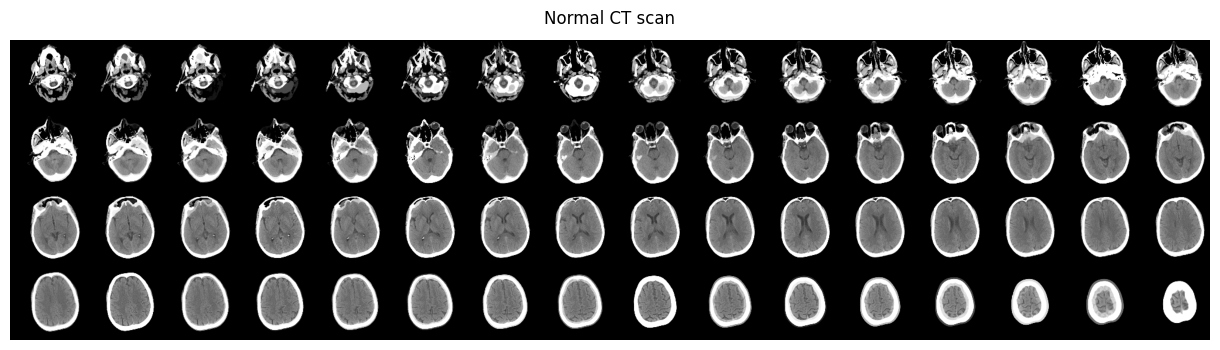

In [22]:
plot_scan_from_dataset(4, 16, 128, 128, normal_dataset[0, :, :, :], "Normal CT scan")

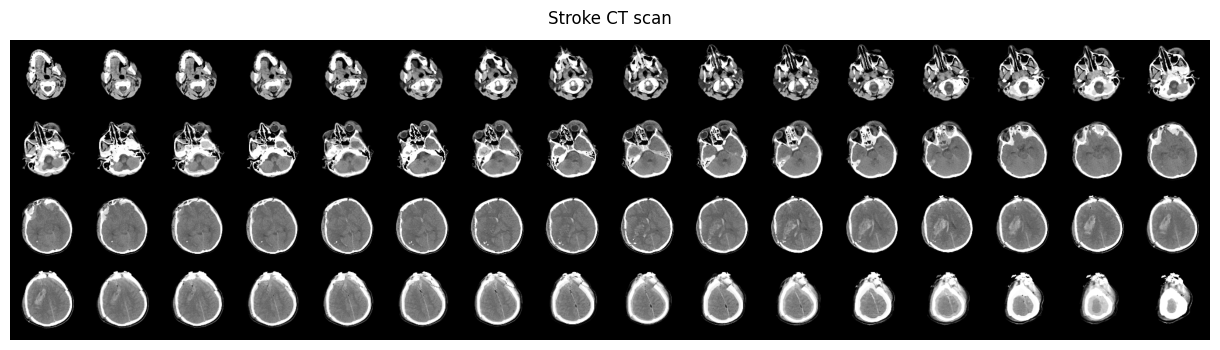

In [23]:
plot_scan_from_dataset(4, 16, 128, 128, stroke_dataset[0, :, :, :], "Stroke CT scan")

Both the datasets are now splitted and merged into `training` and `validation` datasets with a ratio of 70% and 30%.

In [24]:
# For the CT scans having presence of stroke assign 1 otherwise 0.
normal_labels = np.array([0 for _ in range(len(normal_dataset))])
stroke_labels = np.array([1 for _ in range(len(stroke_dataset))])

# Split data in the ratio 70%-30% for training and validation.
import math
VALIDATION_SPLIT = 0.7
normal_train_len = math.ceil(VALIDATION_SPLIT*len(normal_labels))
stroke_train_len = math.ceil(VALIDATION_SPLIT*len(stroke_labels))
x_train = np.concatenate((normal_dataset[:normal_train_len], stroke_dataset[:stroke_train_len]), axis=0)
y_train = np.concatenate((normal_labels[:normal_train_len], stroke_labels[:stroke_train_len]), axis=0)
x_val = np.concatenate((normal_dataset[normal_train_len:], stroke_dataset[stroke_train_len:]), axis=0)
y_val = np.concatenate((normal_labels[normal_train_len:], stroke_labels[stroke_train_len:]), axis=0)

print(f"Training samples")
print(f"Normal: {normal_train_len}")
print(f"Stroke: {stroke_train_len}")
print(f"Total: {x_train.shape[0]}")
print()
print(f"Validation samples")
print(f"Normal: {len(normal_dataset) - normal_train_len}")
print(f"Stroke: {len(stroke_dataset) - stroke_train_len}")
print(f"Total: {x_val.shape[0]}")

Training samples
Normal: 36
Stroke: 22
Total: 58

Validation samples
Normal: 15
Stroke: 9
Total: 24


## Dataset augmentation

 A machine learning model performs better and is more accurate when the dataset is rich and sufficient. Deep learning in general, but particularly in medical imaging, requires a large amount of training data in order to obtain good performance and avoid overfitting. To meet these challenges, increasing the quantity of training data is a common solution. Data augmentation is a common approach to enhance the performance and the results of machine learning models. It allows a small dataset to be rebalanced or enriched for any reason (time-consuming manual annotations, lack of accessible data...). The augmentation techniques must make sense with respect to the type of analysis desired and therefore positively influence the performance of the model during the learning phase: by applying a large number of augmentations, the performance will not necessarily be better. There are several types of transformations for medical images, but few examples which can be seen as good starting point for CT scans are provided in the following.

### Rotation

This transformation consists of rotating the original image according to a desired angle. In medical image analysis, this  represents a common augmentation technique. In this case the scan is rotated around z-axis by a random angle in the interval `[-45, 45]` degrees.

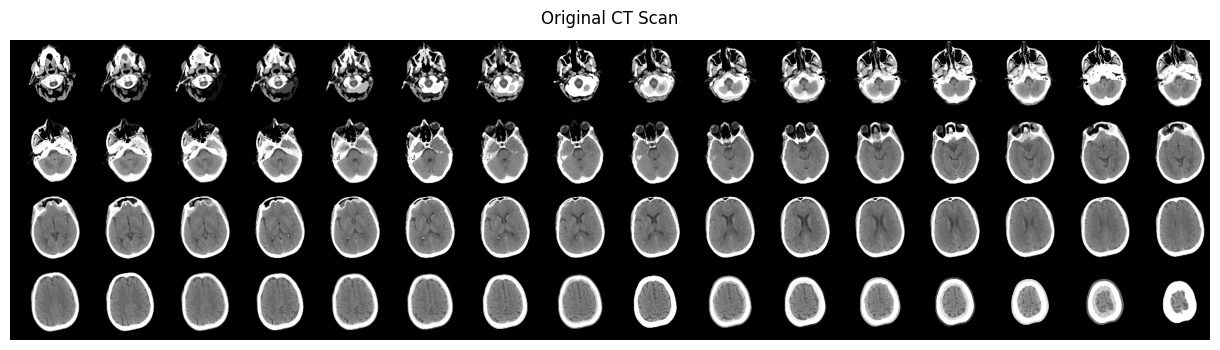

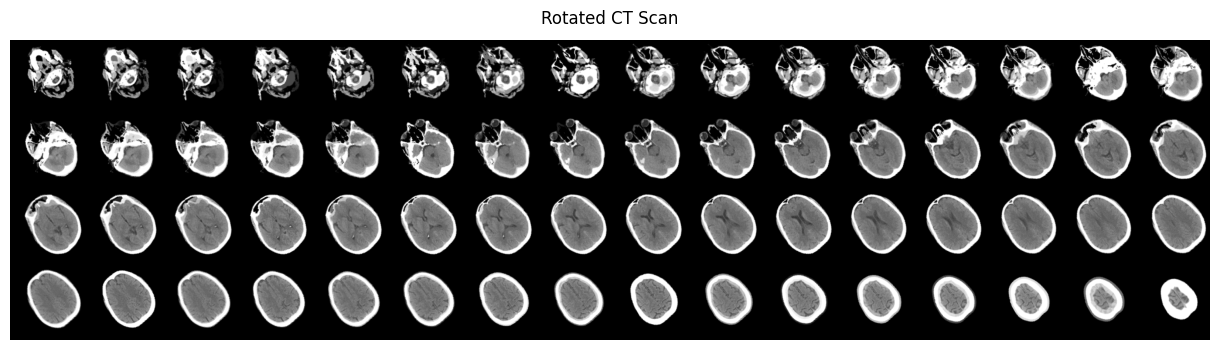

In [25]:
rotation_layer = tf.keras.layers.RandomRotation(factor=(-0.125, 0.125), fill_mode='constant', fill_value=0)

plot_scan_from_dataset(4, 16, 128, 128, x_train[0, :, :, :], "Original CT Scan")
plot_scan_from_dataset(4, 16, 128, 128, rotation_layer(x_train[0, :, :, :]), "Rotated CT Scan")

### Flip

The image flips are performed along an axis of symmetry. For medical image enhancement, they can be performed vertically as well as horizontally, because images can be acquired in supine or prone position, and contain anatomical variations (e.g., situs inversus). An organ, whatever its location in the body, will always be the same organ.

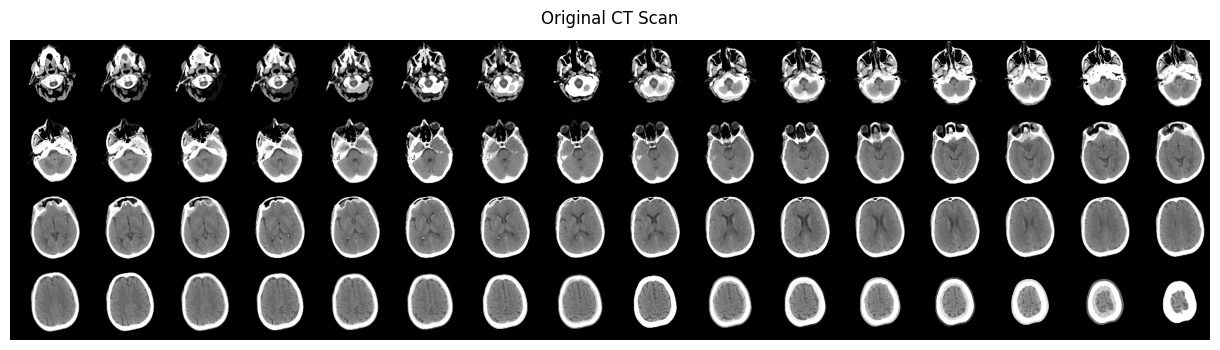

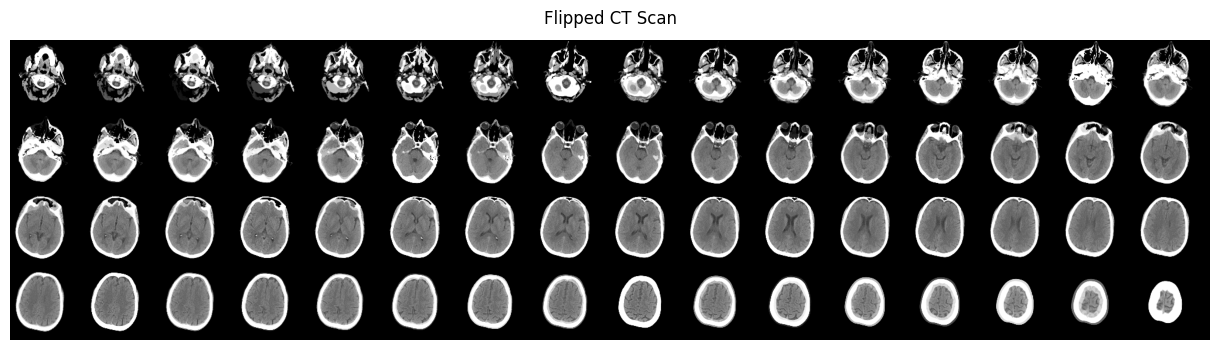

In [26]:
flipping_layer = tf.keras.layers.RandomFlip(mode='vertical')

plot_scan_from_dataset(4, 16, 128, 128, x_train[0, :, :, :], "Original CT Scan")
plot_scan_from_dataset(4, 16, 128, 128, flipping_layer(x_train[0, :, :, :]), "Flipped CT Scan")

### Shift

This transformation can be performed along the x and/or y axis randomly. The transformed image keeps the same size and orientation as the original image, but is moved in the applied direction. The added pixels are filled with zeros.

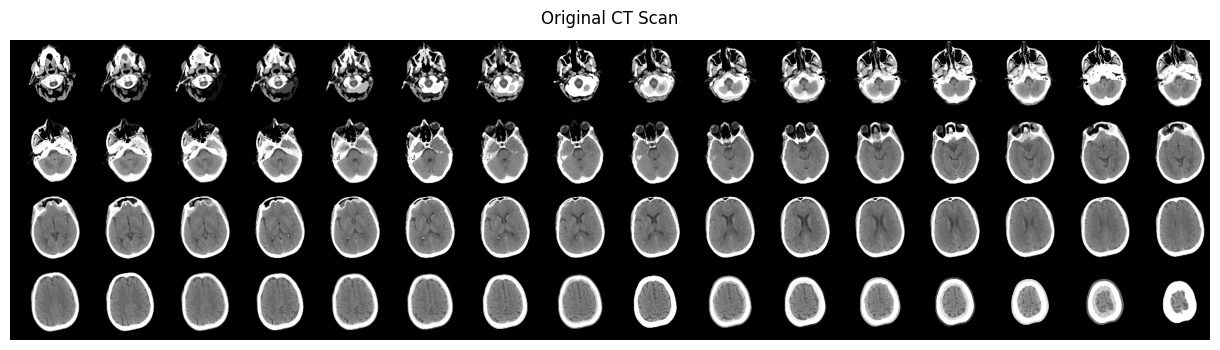

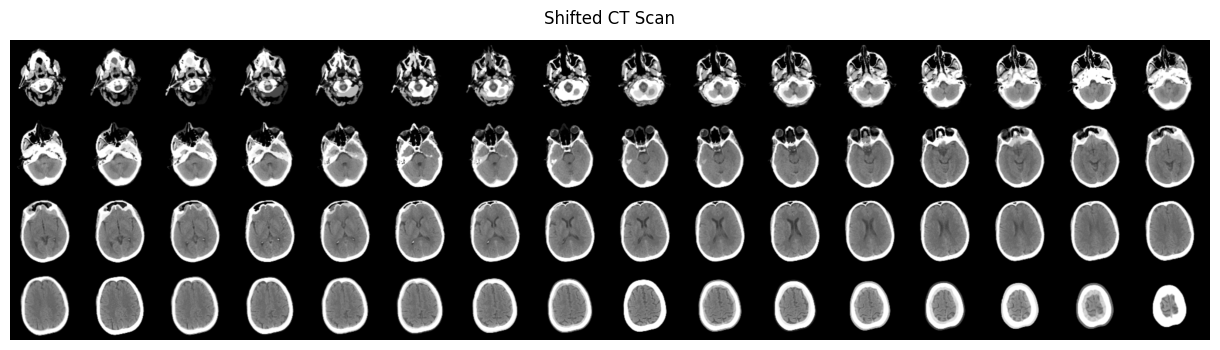

In [27]:
shifting_layer = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', fill_value=0)

plot_scan_from_dataset(4, 16, 128, 128, x_train[0, :, :, :], "Original CT Scan")
plot_scan_from_dataset(4, 16, 128, 128, shifting_layer(x_train[0, :, :, :]), "Shifted CT Scan")

### Zoom

A zoom augmentation randomly zooms the image in or out. The zoomed image keeps the same size and orientation as the original image.

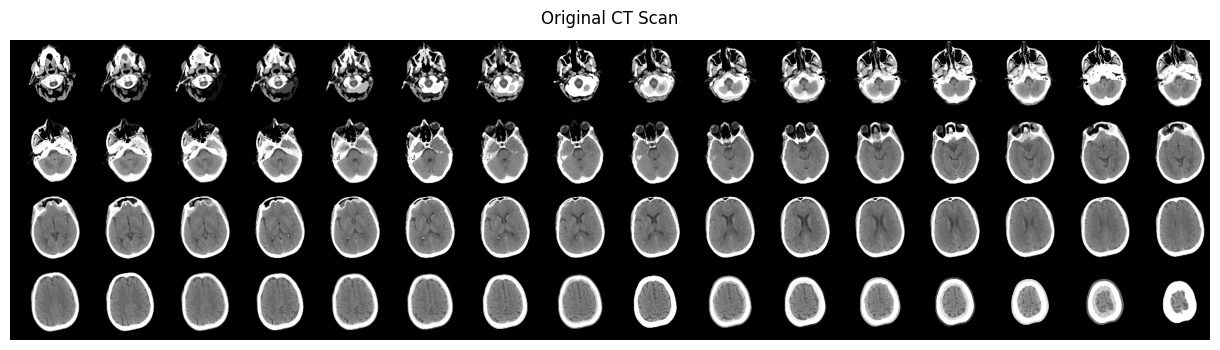

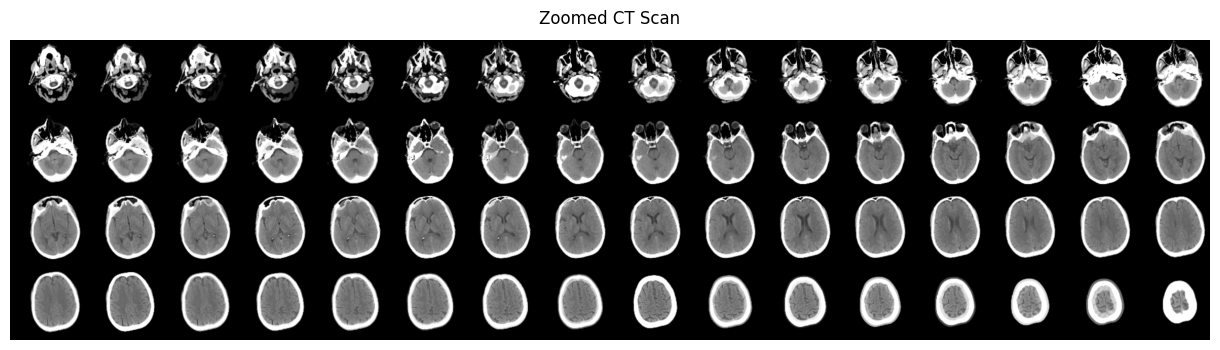

In [28]:
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.15, fill_mode='constant', fill_value=0)

plot_scan_from_dataset(4, 16, 128, 128, x_train[0, :, :, :], "Original CT Scan")
plot_scan_from_dataset(4, 16, 128, 128, zoom_layer(x_train[0, :, :, :]), "Zoomed CT Scan")

### Shear

Shearing is an affine transformation that consists of shifting in opposite directions the top and bottom of the image (horizontal shearing) or the right and left of the image (vertical shearing). Unlike the previous methods, the image is distorted. Shear augmentation is not available in `tensorflow` so the `keras_cv` package must be installed.

In [29]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 kB 13.2 MB/s eta 0:00:00


You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


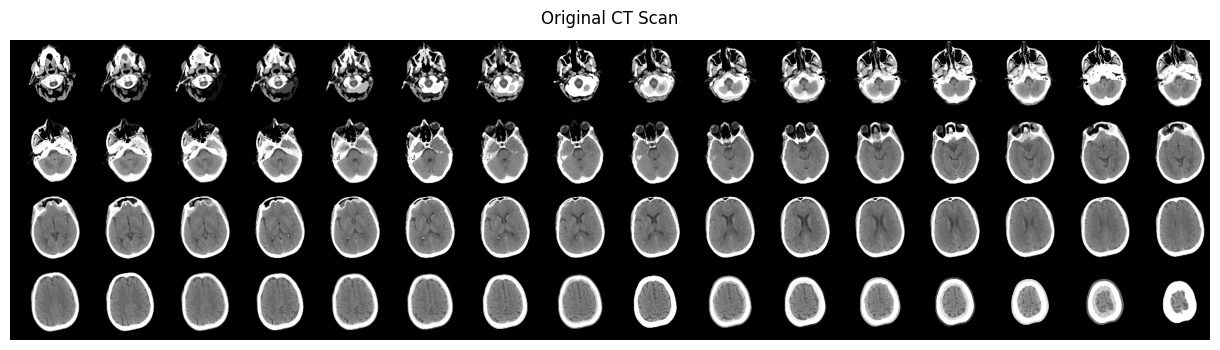

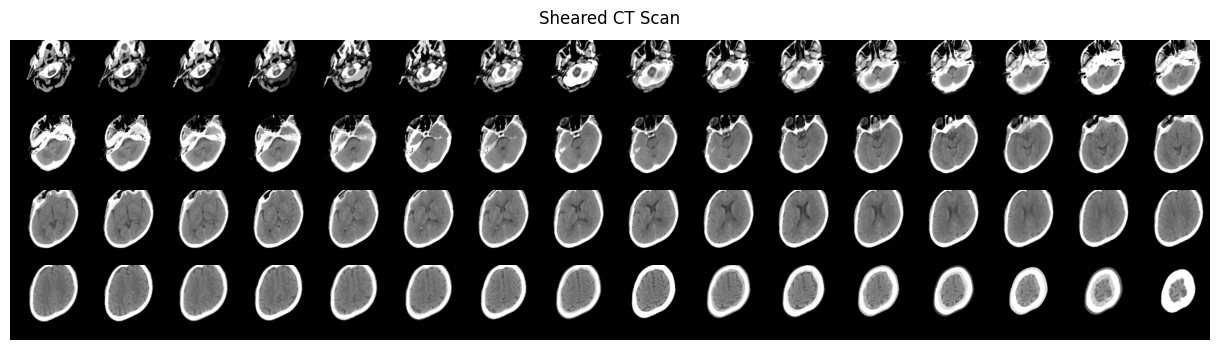

In [30]:
import keras_cv

shear_layer = keras_cv.layers.RandomShear(x_factor=(0, 0.3), y_factor=(0, 0.3), interpolation="bilinear", fill_mode="nearest", fill_value=0.0)

plot_scan_from_dataset(4, 16, 128, 128, x_train[0, :, :, :], "Original CT Scan")
plot_scan_from_dataset(4, 16, 128, 128, shear_layer(x_train[0, :, :, :]), "Sheared CT Scan")

### Brightness

The higher the value of the brighteness, the lighter is the image. In order to increase the size of the data set in medical imaging, brightness variations belonging to the interval `[-0.1; 0.1]` are randomly applied.

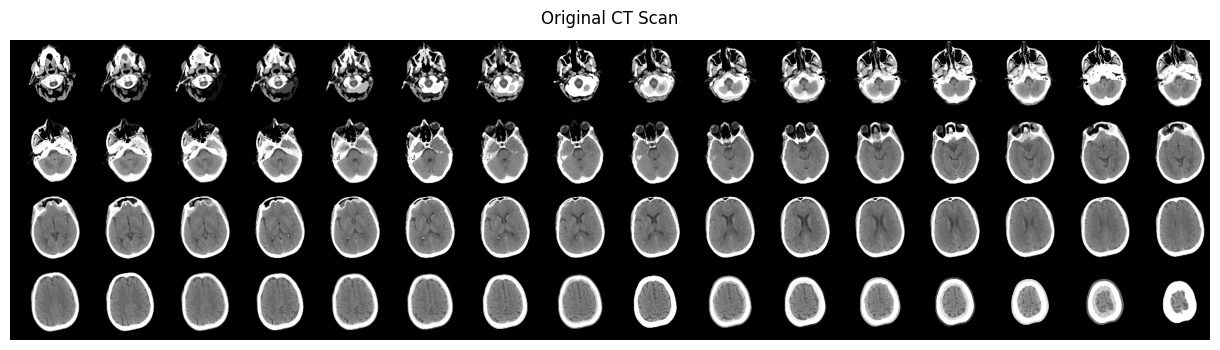

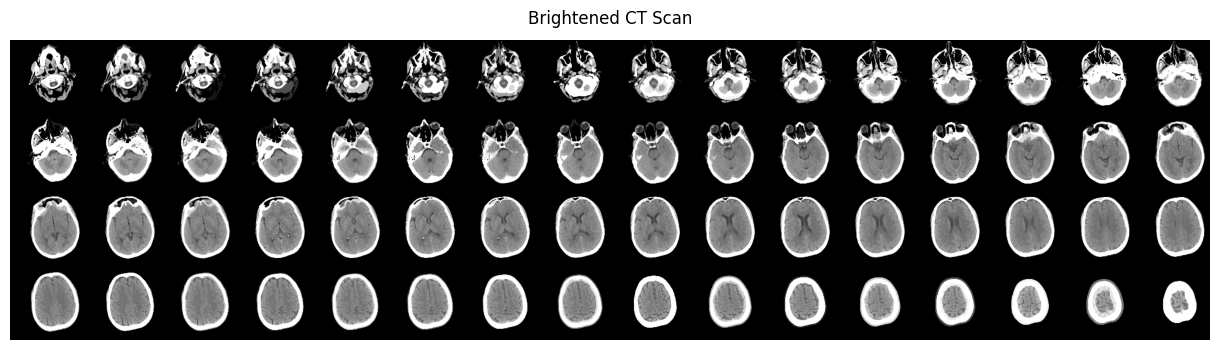

In [31]:
brighteness_layer = tf.keras.layers.RandomBrightness(factor=0.1, value_range=[0.0, 1.0])

plot_scan_from_dataset(4, 16, 128, 128, x_train[0, :, :, :], "Original CT Scan")
plot_scan_from_dataset(4, 16, 128, 128, brighteness_layer(x_train[0, :, :, :]), "Brightened CT Scan")

## Contrast

The contrast of an image is increased when the darker pixels are darkened and the lighter pixels are lightened: a contrasted image will therefore contain a greater quantity of black and white. The contrast increase is clearly visible on image histogram, because the gap between the brightest and the darkest pixels is greater, i.e., the histogram is more spread out.

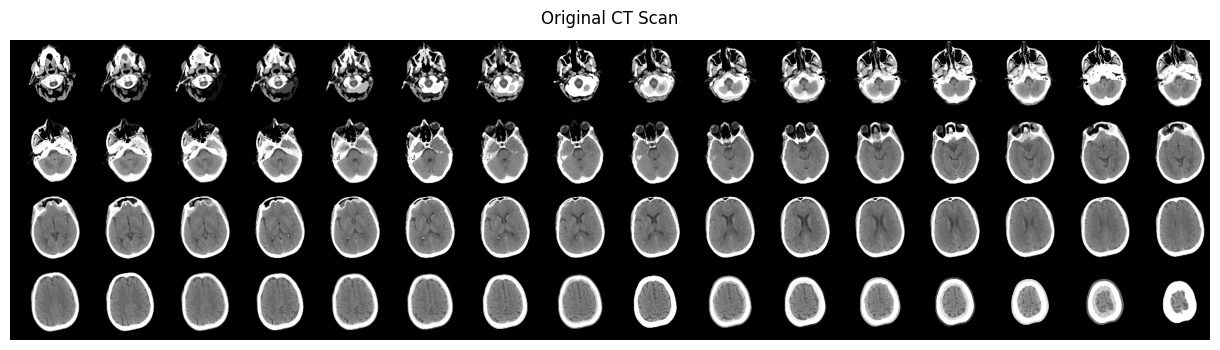

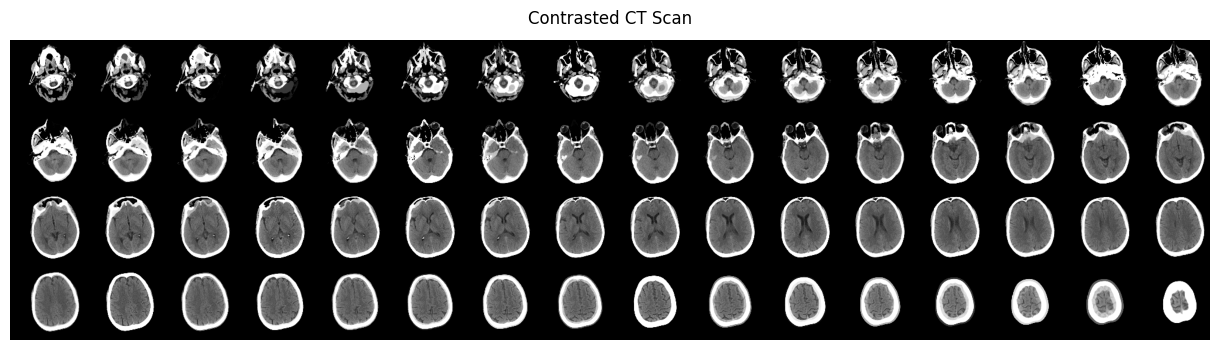

In [32]:
contrast_layer = tf.keras.layers.RandomContrast(factor=(0, 1.2))

plot_scan_from_dataset(4, 16, 128, 128, x_train[0, :, :, :], "Original CT Scan")
plot_scan_from_dataset(4, 16, 128, 128, contrast_layer(x_train[0, :, :, :]), "Contrasted CT Scan")

The training and validation data loaders must be defined. In this case, data augmentation is not applied through the data loader but directly on the CNN by adding the related augmentation layers.

In [33]:
# Set TensorFlow random seed
tf.random.set_seed(42)

# Define data loaders
training_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Define batch size
batch_size = 2

# Training dataset
training_dataset = (
    training_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)

# Validation dataset
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

## Model definition



The architecture of the 3D CNN is the same used [here](https://keras.io/examples/vision/3D_image_classification/), but, as already said, the CT scans are optionally augmented by passing them through some augmentation layers which have been directly embedded into the model. A reshape layer has also been added since the data is stored in rank-3 tensors of shape (samples, height, width, depth), a dimension of size 1 at axis 4 is needed in order to be able to perform 3D convolutions on the data. The additional dimension is needed to take into account the number of image channel which in this case is just 1.

In [34]:
from tensorflow import keras
from tensorflow.keras import layers

# Default arguments
WIDTH=128
HEIGHT=128
DEPTH=64
INITIAL_LEARNING_RATE=0.0001
DECAY_STEPS=100000
DECAY_RATE=0.96

# Performance metrics
METRICS=[
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def build_model(width=WIDTH, 
                height=HEIGHT, 
                depth=DEPTH, 
                initial_learning_rate=INITIAL_LEARNING_RATE, 
                decay_steps=DECAY_STEPS, 
                decay_rate=DECAY_RATE,
                metrics=METRICS,
                augmentation=False,
                rotation=False,
                flip=False,
                shift=False,
                zoom=False,
                shear=False,
                brightness=False,
                contrast=False):
  """Build a 3D convolutional neural network model with augmentation layers"""

  # Define the model
  model = keras.Sequential()
  model.add(keras.Input((width, height, depth)))

  # (Optionally) Add augmentation layers
  if augmentation:
    if rotation:
      model.add(layers.RandomRotation(factor=(-0.125, 0.125), fill_mode='constant', fill_value=0))
    if flip:
      model.add(layers.RandomFlip(mode='vertical'))
    if shift:
      model.add(layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', fill_value=0))
    if zoom:
      model.add(layers.RandomZoom(height_factor=0.15, fill_mode='constant', fill_value=0))
    if shear:
      model.add(keras_cv.layers.RandomShear(x_factor=(0, 0.3), y_factor=(0, 0.3), interpolation="bilinear", fill_mode="nearest", fill_value=0.0))
    if brightness:
      model.add(layers.RandomBrightness(factor=0.1, value_range=[0.0, 1.0]))
    if contrast:
      model.add(layers.RandomContrast(factor=(0, 1.2)))

  # Add a dimension to perform 3D convolutions
  model.add(layers.Reshape(target_shape=(width, height, depth, 1)))

  model.add(layers.Conv3D(filters=64, kernel_size=3, activation="relu"))
  model.add(layers.MaxPool3D(pool_size=2))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv3D(filters=64, kernel_size=3, activation="relu"))
  model.add(layers.MaxPool3D(pool_size=2))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv3D(filters=128, kernel_size=3, activation="relu"))
  model.add(layers.MaxPool3D(pool_size=2))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv3D(filters=256, kernel_size=3, activation="relu"))
  model.add(layers.MaxPool3D(pool_size=2))
  model.add(layers.BatchNormalization())

  model.add(layers.GlobalAveragePooling3D())
  model.add(layers.Dense(units=512, activation="relu"))
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(units=1, activation="sigmoid"))

  # Define the optimizer
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True
  )

  # Compile the model
  model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=metrics,
  )
    
  return model

In [35]:
# Build the model with default parameters
model = build_model()

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 128, 64, 1)   0         
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 30, 14, 64)   0

## Model training

The proposed model will be trained by default for 150 epochs in 4 different conditions:

- **Absent augmentation**: all augmentation layers disabled
- **Basic augmentation**: brightness and contrast layers enabled
- **Intermediate augmentation**: brightness, contrast, rotation, flip and shift layers enabled
- **Advanced augmentation**: all augmentation layers enabled

It is worth noting a **Checkpoint callback** is also defined to automatically save the model in `h5` format based on the validation Receiver Operating Characteristics Area Under Curve (ROC AUC) value. Please note the ROC AUC is preferred to the standard classification accuracy since the dataset is not balanced.

In [36]:
# Default epochs number
EPOCHS=150

# Callback
CHECKPOINT_CB = keras.callbacks.ModelCheckpoint(
    "ct-scan-brain-stroke-detection-{epoch:03d}-{val_auc:.4f}.h5", 
    save_best_only=True, 
    monitor='val_auc', 
    mode='max'
)

# Model training function
def train_model(model, training_dataset, validation_dataset, epochs=EPOCHS, callbacks=[CHECKPOINT_CB]):
  """Train a model doing validation at the end of each epoch"""
  history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=callbacks
  )

  return history

An empty dictionary to store model metrics is also created to store all the metrics.

In [37]:
performance = {}

### Absent augmentation

In this case the data augmentation is completely disabled. The model will be trained by using only the CT scans already available in the training dataset.

In [38]:
model = build_model()

performance["absent"] = train_model(model, training_dataset, validation_dataset)

Epoch 1/150
29/29 [==============================] - 27s 197ms/step - loss: 0.7002 - tp: 6.0000 - fp: 14.0000 - tn: 22.0000 - fn: 16.0000 - accuracy: 0.4828 - precision: 0.3000 - recall: 0.2727 - auc: 0.4236 - prc: 0.3796 - val_loss: 0.6891 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 15.0000 - val_fn: 9.0000 - val_accuracy: 0.6250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6741 - val_prc: 0.5665
Epoch 2/150
29/29 [==============================] - 5s 170ms/step - loss: 0.6772 - tp: 9.0000 - fp: 7.0000 - tn: 29.0000 - fn: 13.0000 - accuracy: 0.6552 - precision: 0.5625 - recall: 0.4091 - auc: 0.5852 - prc: 0.4299 - val_loss: 0.6758 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 15.0000 - val_fn: 9.0000 - val_accuracy: 0.6250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6556 - val_prc: 0.6161
Epoch 3/150
29/29 [==============================] - 5s 172ms/step - loss: 0.6412 - tp: 13.0000 - fp: 8.0000 - tn: 28.0000 - fn: 9.0000 - accu

### Basic augmentation

The basic augmentation is very light since it just enables the brightness and contrast layers. The expected results are not much better with respect to the previous case.

In [39]:
model = build_model(augmentation=True,
                    rotation=False,
                    flip=False,
                    shift=False,
                    zoom=False,
                    shear=False,
                    brightness=True,
                    contrast=True)

performance["basic"] = train_model(model, training_dataset, validation_dataset)

Epoch 1/150
29/29 [==============================] - 10s 199ms/step - loss: 0.6830 - tp: 12.0000 - fp: 12.0000 - tn: 39.0000 - fn: 19.0000 - accuracy: 0.6220 - precision: 0.5000 - recall: 0.3871 - auc: 0.5569 - prc: 0.4748 - val_loss: 0.6913 - val_tp: 5.0000 - val_fp: 6.0000 - val_tn: 9.0000 - val_fn: 4.0000 - val_accuracy: 0.5833 - val_precision: 0.4545 - val_recall: 0.5556 - val_auc: 0.6296 - val_prc: 0.4677
Epoch 2/150
29/29 [==============================] - 5s 177ms/step - loss: 0.6188 - tp: 10.0000 - fp: 4.0000 - tn: 32.0000 - fn: 12.0000 - accuracy: 0.7241 - precision: 0.7143 - recall: 0.4545 - auc: 0.7664 - prc: 0.7183 - val_loss: 0.7491 - val_tp: 9.0000 - val_fp: 15.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.3750 - val_precision: 0.3750 - val_recall: 1.0000 - val_auc: 0.6000 - val_prc: 0.5361
Epoch 3/150
29/29 [==============================] - 5s 178ms/step - loss: 0.6501 - tp: 9.0000 - fp: 7.0000 - tn: 29.0000 - fn: 13.0000 - accuracy: 0.6552 - precisio

### Intermediate augmentation

Additional layers, i.e., rotation, flip and shift, are enabled which will deeply enrich the training dataset. 

In [40]:
model = build_model(augmentation=True,
                    rotation=True,
                    flip=True,
                    shift=True,
                    zoom=False,
                    shear=False,
                    brightness=True,
                    contrast=True)

performance["intermediate"] = train_model(model, training_dataset, validation_dataset)

Epoch 1/150
29/29 [==============================] - 10s 199ms/step - loss: 0.7231 - tp: 16.0000 - fp: 27.0000 - tn: 24.0000 - fn: 15.0000 - accuracy: 0.4878 - precision: 0.3721 - recall: 0.5161 - auc: 0.4956 - prc: 0.3989 - val_loss: 0.6800 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 15.0000 - val_fn: 9.0000 - val_accuracy: 0.6250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.3750
Epoch 2/150
29/29 [==============================] - 5s 181ms/step - loss: 0.6889 - tp: 3.0000 - fp: 8.0000 - tn: 28.0000 - fn: 19.0000 - accuracy: 0.5345 - precision: 0.2727 - recall: 0.1364 - auc: 0.4356 - prc: 0.3383 - val_loss: 0.6677 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 15.0000 - val_fn: 9.0000 - val_accuracy: 0.6250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3333 - val_prc: 0.2886
Epoch 3/150
29/29 [==============================] - 5s 182ms/step - loss: 0.6853 - tp: 4.0000 - fp: 4.0000 - tn: 32.0000 - fn: 18.0000 - acc

### Advanced augmentation

The advanced approach is more aggressive since it includes zoom and even shear augmentation. As already specified, the latter also introduces an image distortion.

In [41]:
model = build_model(augmentation=True,
                    rotation=True,
                    flip=True,
                    shift=True,
                    zoom=True,
                    shear=True,
                    brightness=True,
                    contrast=True)

performance["advanced"] = train_model(model, training_dataset, validation_dataset)

Epoch 1/150


29/29 [==============================] - 12s 203ms/step - loss: 0.7046 - tp: 14.0000 - fp: 22.0000 - tn: 29.0000 - fn: 17.0000 - accuracy: 0.5244 - precision: 0.3889 - recall: 0.4516 - auc: 0.5427 - prc: 0.4471 - val_loss: 0.6764 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 15.0000 - val_fn: 9.0000 - val_accuracy: 0.6250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4222 - val_prc: 0.3302
Epoch 2/150
29/29 [==============================] - 5s 180ms/step - loss: 0.6903 - tp: 2.0000 - fp: 7.0000 - tn: 29.0000 - fn: 20.0000 - accuracy: 0.5345 - precision: 0.2222 - recall: 0.0909 - auc: 0.4848 - prc: 0.3495 - val_loss: 0.7282 - val_tp: 9.0000 - val_fp: 15.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.3750 - val_precision: 0.3750 - val_recall: 1.0000 - val_auc: 0.5778 - val_prc: 0.4324
Epoch 3/150
29/29 [==============================] - 5s 183ms/step - loss: 0.6244 - tp: 7.0000 - fp: 7.0000 - tn: 29.0000 - fn: 15.0000 - accuracy: 0.6207 - prec

## Performance evaluation

Once the training is completed, the model performance can be plotted. Since the validation set is unbalanced, as already specified, the ROC AUC is used to provide a representation of the model's performance.

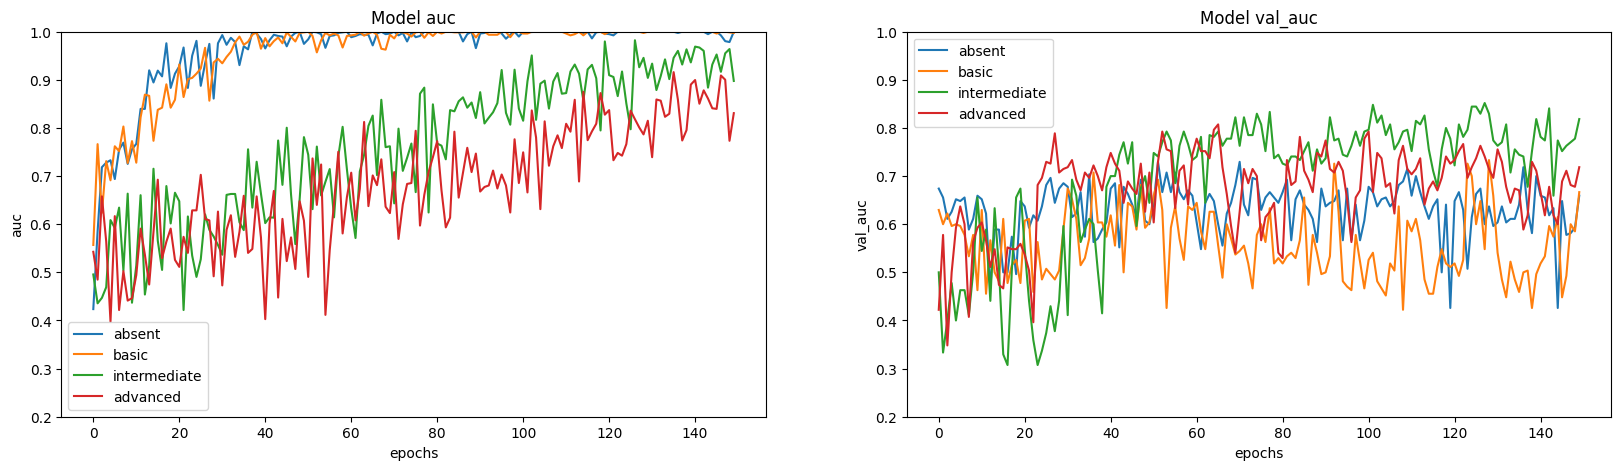

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, metric in enumerate(["auc", "val_auc"]):
  for label, history in performance.items():
    ax[i].plot(history.history[metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].set_ylim([0.2, 1])
    ax[i].legend(performance.keys())

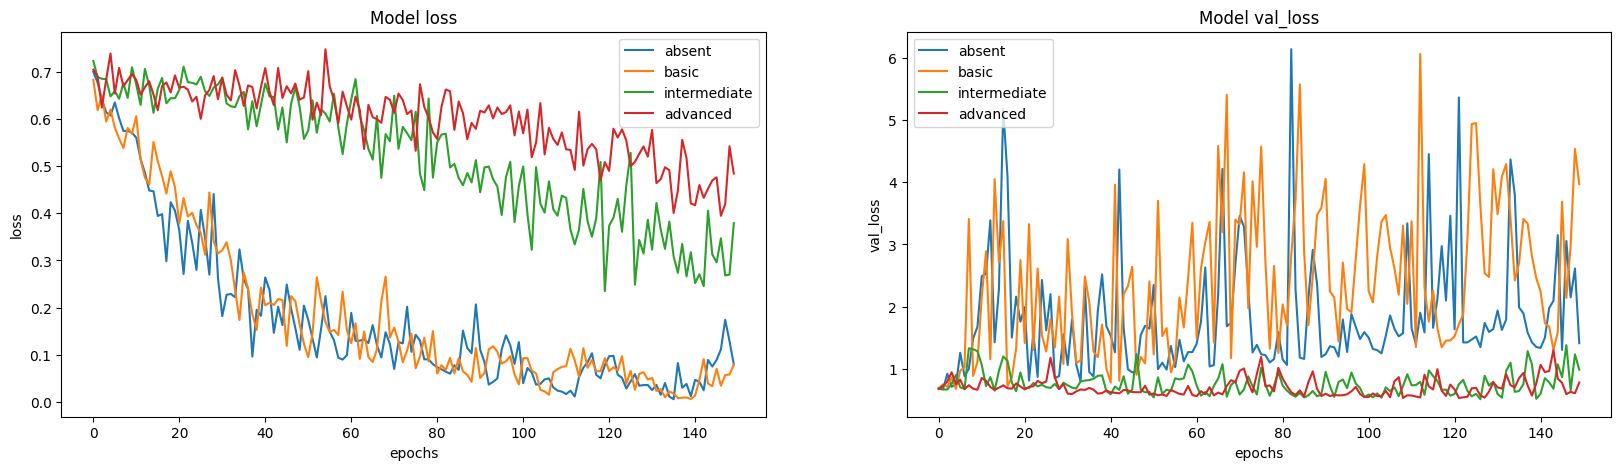

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, metric in enumerate(["loss", "val_loss"]):
  for label, history in performance.items():
    ax[i].plot(history.history[metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(performance.keys())

## References

- [3D image classification from CT scans](https://keras.io/examples/vision/3D_image_classification/)
- [Medical Images In python (Computed Tomography)](https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography)
- [Data augmentation for medical image analysis in deep learning](https://www.imaios.com/en/resources/blog/ai-for-medical-imaging-data-augmentation)